In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# import csv file with trading activity
portfolio_activity = pd.read_csv('activity_files/qgarp_activity.csv', header=1)

In [3]:
# adjust date column to be datetime object
portfolio_activity['Date'] = pd.to_datetime(portfolio_activity['Date'])
portfolio_activity['Date'] = portfolio_activity['Date'].dt.date
portfolio_activity.replace('FB', 'META', inplace=True)
portfolio_activity.replace('CR', 'CXT', inplace=True)

In [4]:
portfolio_activity.head()

,Account Number,Date,Activity,Description,Symbol,Cusip,Type,Quantity,Price,Amount,Friendly Account Name
0,VU 28934,2023-04-25,DIVIDEND,DOLLAR GEN CORP NEW PAID ON 7,DG,256677105,Cash,NaN,NaN,4.13,JL QGARP
1,VU 28934,2023-04-25,FEE CHARGED,Current Quarter Advisory Fee,NaN,NaN,Cash,NaN,NaN,-135.47,JL QGARP
2,VU 28934,2023-04-21,SOLD,PALO ALTO NETWORKS INC UNSOLICITED,PANW,697435105,Investment,-1.0,192.3564,192.35,JL QGARP
3,VU 28934,2023-04-20,SOLD,PALO ALTO NETWORKS INC UNSOLICITED,PANW,697435105,Investment,-1.0,192.2301,192.22,JL QGARP
4,VU 28934,2023-04-19,BOUGHT,ADVANCED MICRO DEVICES INC,AMD,007903107,Investment,12.0,89.8395,-1078.07,JL QGARP


In [5]:
start_date = portfolio_activity.tail(1)['Date'].values[0]
end_date = portfolio_activity.head(1)['Date'].values[0]

In [6]:
all_tickers = portfolio_activity[portfolio_activity['Type'] == 'Investment']['Symbol'].unique()
all_tickers = [x for x in all_tickers if type(x) == str]

In [7]:
stock_price_data = yf.download(all_tickers, start=start_date, end=end_date)['Close']
benchmark_price_data = yf.download(['SPY','ONEQ','IWF'], start=start_date, end=end_date)['Close']

stock_price_data.replace(np.nan,0,inplace=True)

[*********************100%***********************]  47 of 47 completed
[*********************100%***********************]  3 of 3 completed


In [8]:
split_df = pd.DataFrame(columns=['Symbol','Split_Date','Split_Multiple'])

for ticker in all_tickers:
    split = yf.Ticker(ticker).splits
    split_dates = split.index.date
    split_multiple = split.values
    split_index = np.where((start_date <= split_dates) & (split_dates <= end_date))
    
    if len(split_index[0]) != 0:
        split_dates = split.index.date
        split_df.loc[len(split_df)] = [ticker, split_dates[split_index], int(split_multiple[split_index])]
        
        
for row in split_df.iterrows():
    pre_split = np.where(stock_price_data[row[1]['Symbol']].index.date < split_df[split_df['Symbol'] == row[1]['Symbol']]['Split_Date'].iloc[0][0])
    stock_price_data[row[1]['Symbol']].iloc[pre_split] = stock_price_data[row[1]['Symbol']].iloc[pre_split]*split_df[split_df['Symbol'] == row[1]['Symbol']]['Split_Multiple'].values[0]

In [44]:
def update_portfolio(trading_activity, daily_pricing_data, benchmark_price_data):
    
    start_date = trading_activity.tail(1)['Date'].values[0]
    end_date = trading_activity.head(1)['Date'].values[0]
    #end_date = dt.date(2020,12,29)
    date = start_date
    
    cash = 0
    transfer_amount = 0
    benchmark_shares = 0
    
    daily_portfolio = pd.DataFrame()
    portfolio_value_df = pd.DataFrame(columns=['Date', 'Portfolio_Value'])
    
    while date <= end_date:
        
        if date not in benchmark_price_data.index.date:
            date += dt.timedelta(days=1)
            continue
                
        else:
            
            investment_transfers = trading_activity[(trading_activity['Activity'].isin(['TRANSFER', 'RECEIVE DTC', 'RECEIVE']))
                                                  & (trading_activity['Date'] == date) 
                                                  & (trading_activity['Type'] == 'Investment')]
            
            investment_transfer_value = np.dot(investment_transfers['Quantity'].tolist(), 
                                               investment_transfers['Price'].tolist())
            
            investment_sale_value = trading_activity[(trading_activity['Activity'] == 'SOLD')
                                              & (trading_activity['Date'] == date) 
                                              & (trading_activity['Symbol'] != None)]['Amount'].sum()
            
            investment_purchase_value = trading_activity[(trading_activity['Activity'] == 'BOUGHT')
                                              & (trading_activity['Date'] == date) 
                                              & (trading_activity['Symbol'] != None)]['Amount'].sum()
            
            
            
            benchmark_shares += investment_transfer_value/benchmark_price_data['IWF'].loc[str(date)]
            benchmark_shares -= investment_purchase_value/benchmark_price_data['IWF'].loc[str(date)]
            benchmark_shares -= investment_sale_value/benchmark_price_data['IWF'].loc[str(date)]
            benchmark_value = benchmark_shares*benchmark_price_data['IWF'].loc[str(date)]
            
            
            
            daily_stock_trades = trading_activity[(trading_activity['Date'] == date) 
                                                  & (trading_activity['Type'] == 'Investment')]
        
            
            daily_portfolio = pd.concat([daily_portfolio, daily_stock_trades]).groupby(['Symbol'], as_index=False).agg(
                                                    {'Account Number':'first','Date':'first','Activity':'first',
                                                    'Description':'first','Cusip':'first', 'Type':'first',
                                                    'Quantity':'sum', 'Price':'first', 'Amount':'first',
                                                    'Friendly Account Name':'first'})
        
            daily_portfolio = daily_portfolio[daily_portfolio['Quantity'] != 0]
        
            daily_cash_changes = trading_activity[(trading_activity['Date'] == date) 
                                                & (trading_activity['Type'] == 'Cash')]['Amount'].sum()
            
            daily_investment_changes = trading_activity[(trading_activity['Date'] == date) 
                                                      & (trading_activity['Type'] == 'Investment')]['Amount'].sum()
        
            total_daily_cash_changes = daily_cash_changes + daily_investment_changes
            cash += total_daily_cash_changes
        
        
            daily_prices = daily_pricing_data[daily_portfolio['Symbol'].values.tolist()].loc[dt.datetime.combine(date,dt.time(0,0,0))]  
        
            investment_value = np.dot(daily_prices.T.tolist(), daily_portfolio['Quantity'].tolist())
            portfolio_value = investment_value + cash
            
            
            total_benchmark_value = benchmark_value + cash
            
            
            portfolio_value_df = pd.concat([portfolio_value_df, pd.DataFrame({'Date':[date], 'Portfolio_Value':[portfolio_value], 
                                            'Benchmark_Value':[total_benchmark_value]})], ignore_index=True)
        
            date += dt.timedelta(days=1)
            
    
    final_portfolio = daily_portfolio[['Symbol', 'Description', 'Quantity']]
    final_portfolio['Price'] = daily_prices.values
    
    return(portfolio_value, final_portfolio, portfolio_value_df, cash, investment_value)

In [45]:
value, portfolio, df, cash_amount, investment_amount = update_portfolio(portfolio_activity, stock_price_data, benchmark_price_data)

/var/folders/4_/s2ms7ywj2x1bjmfstg8p1jt80000gn/T/ipykernel_97014/722251872.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_portfolio['Price'] = daily_prices.values


In [46]:
value

110101.86942642214

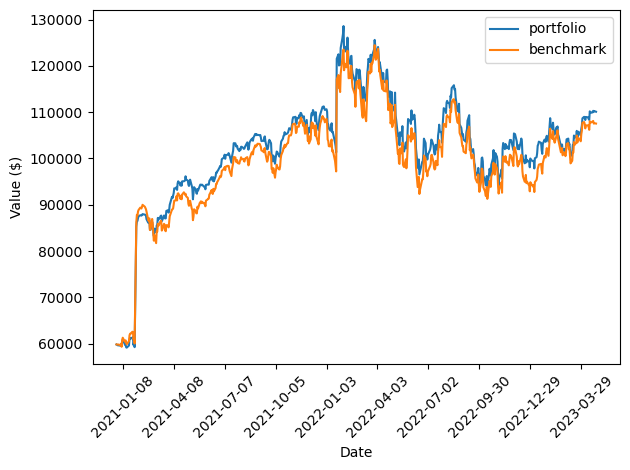

In [70]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(df['Date'],df['Portfolio_Value'], label='portfolio')
ax.plot(df['Date'],df['Benchmark_Value'], label='benchmark')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=90))
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('Date')

ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.set_ylabel('Value ($)')

ax.legend()
plt.tight_layout()
#plt.savefig('charts/returns.pdf')

In [74]:
yearly_returns_df = pd.DataFrame(columns=['Year', 'Portfolio_Return', 'Benchmark_Return'])

In [73]:
df['Date'].values

array([datetime.date(2020, 12, 28), datetime.date(2020, 12, 29),
       datetime.date(2020, 12, 30), datetime.date(2020, 12, 31),
       datetime.date(2021, 1, 4), datetime.date(2021, 1, 5),
       datetime.date(2021, 1, 6), datetime.date(2021, 1, 7),
       datetime.date(2021, 1, 8), datetime.date(2021, 1, 11),
       datetime.date(2021, 1, 12), datetime.date(2021, 1, 13),
       datetime.date(2021, 1, 14), datetime.date(2021, 1, 15),
       datetime.date(2021, 1, 19), datetime.date(2021, 1, 20),
       datetime.date(2021, 1, 21), datetime.date(2021, 1, 22),
       datetime.date(2021, 1, 25), datetime.date(2021, 1, 26),
       datetime.date(2021, 1, 27), datetime.date(2021, 1, 28),
       datetime.date(2021, 1, 29), datetime.date(2021, 2, 1),
       datetime.date(2021, 2, 2), datetime.date(2021, 2, 3),
       datetime.date(2021, 2, 4), datetime.date(2021, 2, 5),
       datetime.date(2021, 2, 8), datetime.date(2021, 2, 9),
       datetime.date(2021, 2, 10), datetime.date(2021, 2, 11),


In [60]:
from pandas.tseries.offsets import BMonthEnd
from datetime import date

start_date = df['Date'][0]

d=date.today()

#Last day of current month
BMonthEnd().rollforward(d)

#Last day of previous month
BMonthEnd().rollback(d)

Timestamp('2023-04-28 00:00:00')

In [61]:
start_date

datetime.date(2020, 12, 28)

In [75]:
yearly_returns_df

,Year,Portfolio_Return,Benchmark_Return
